In [1]:
from src.data import load_jsonl_part

items_df = load_jsonl_part('../data/processed/cleaned_items_df.jsonl', nrows=500000)
reviews_df = load_jsonl_part('../data/processed/cleaned_reviews_df.jsonl', nrows=5000000)

In [2]:
merged_df = reviews_df.merge(items_df, on='parent_asin', how='inner')
merged_df.head()

,rating,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,title,average_rating,rating_number,features,description,price,store,categories,details,subtitle,author
0,5,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-05 14:08:48.923,0,True,All Beauty,Herbivore - Natural Sea Mist Texturizing Salt ...,4.3,384,[],"[If given the choice, weÕd leave most telltale...",NaN,HERBIVORE,[],"{'Hair Type': 'Wavy', 'Material Type Free': 'D...",NaN,NaN
1,4,B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,2020-05-04 18:10:55.070,1,True,All Beauty,All Natural Vegan Dry Shampoo Powder - Eco Fri...,4.0,56,[],[],NaN,Two Goats Apothecary,[],"{'Brand': 'Two Goats Apothecary', 'Item Form':...",NaN,NaN
2,5,B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,2020-05-16 21:41:06.052,2,True,All Beauty,New Road Beauty - Creamsicle - Variety 3 Pack ...,4.4,699,"[Same Great Product, NEW PACKAGING., MOISTURIZ...",[New Road Beauty Paraffin Wax is recommended f...,21.98,New Road Beauty,[],{'Package Dimensions': '10.5 x 6.4 x 1.6 inche...,NaN,NaN
3,1,B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2022-01-28 18:13:50.220,0,True,All Beauty,muaowig Ombre Body Wave Bundles 1B Grey Human ...,1.0,1,[?Hair Bundle Material?:Brazilian Virgin Human...,[Hair Material: Brazilian Virgin Human Hair Bu...,NaN,muaowig,[],"{'Brand': 'muaowig', 'Material': 'Human Hair',...",NaN,NaN
4,5,B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,2020-12-30 10:02:43.534,0,True,All Beauty,Yinhua Electric Nail Drill Kit Portable Profes...,3.5,20,[],[],NaN,Yinhua,[],{'Package Dimensions': '8.5 x 3.82 x 2.24 inch...,NaN,NaN


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# df: purchase-level data (each review = one purchase)
# required cols: user_id, parent_asin, rating, helpful_vote, verified_purchase, main_category

df2 = merged_df.copy()

# Optional: bucket rare categories -> "Other" (helps if many categories)
top_n = 30
top_cats = df2["main_category"].value_counts().head(top_n).index
df2["main_category_bucket"] = np.where(df2["main_category"].isin(top_cats), df2["main_category"], "Other")

# --- Behavior features ---
user_behavior = (
    df2.groupby("user_id")
       .agg(
           n_purchases=("parent_asin", "size"),
           n_products=("parent_asin", "nunique"),
           mean_rating=("rating", "mean"),
           share_verified=("verified_purchase", "mean"),
           mean_helpful=("helpful_vote", "mean"),
       )
       .reset_index()
)

user_behavior["log_purchases"] = np.log1p(user_behavior["n_purchases"])
user_behavior["log_products"] = np.log1p(user_behavior["n_products"])
user_behavior["log_helpful"] = np.log1p(user_behavior["mean_helpful"])

# --- Category mix (shares) ---
user_cat_counts = (
    df2.groupby(["user_id", "main_category_bucket"])
       .size()
       .rename("cat_count")
       .reset_index()
)

user_cat_wide = (
    user_cat_counts.pivot(index="user_id", columns="main_category_bucket", values="cat_count")
                  .fillna(0)
)

user_cat_share = user_cat_wide.div(user_cat_wide.sum(axis=1), axis=0).fillna(0)
user_cat_share.columns = [f"cat_share__{c}" for c in user_cat_share.columns]
user_cat_share = user_cat_share.reset_index()

# --- Combine ---
user_features = (
    user_behavior.merge(user_cat_share, on="user_id", how="left")
                 .fillna(0)
)

feature_cols = (
    ["log_purchases", "log_products", "mean_rating", "share_verified", "log_helpful"]
    + [c for c in user_features.columns if c.startswith("cat_share__")]
)

X = user_features[feature_cols].to_numpy()
X_scaled = StandardScaler().fit_transform(X)

# --- KMeans with 20 segments ---
k = 20
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
user_features["cluster"] = kmeans.fit_predict(X_scaled)

# --- Attach cluster back to purchase-level dataset ---
df_with_clusters = df2.merge(user_features[["user_id", "cluster"]], on="user_id", how="left")

# Display: cluster sizes (by users and by purchases)
users_per_cluster = user_features["cluster"].value_counts().sort_index()
purchases_per_cluster = df_with_clusters["cluster"].value_counts().sort_index()

users_per_cluster, purchases_per_cluster


(cluster
 0     300242
 1      10202
 2     600109
 3        428
 4     442492
 5       7173
 6      83303
 7        952
 8        208
 9     438245
 10    575240
 11    178751
 12         1
 13      6365
 14       664
 15     24674
 16      6361
 17      2260
 18       548
 19      2203
 Name: count, dtype: int64,
 cluster
 0      386221
 1       12323
 2      702992
 3         512
 4      477912
 5        8750
 6      100268
 7        1116
 8         229
 9      484090
 10     616555
 11    1103635
 12          6
 13       7714
 14        798
 15      29567
 16       7309
 17       2854
 18        639
 19       2679
 Name: count, dtype: int64)

### 1) Show a few example purchases from each cluster

In [4]:
(df_with_clusters
 .sort_values(["cluster"])
 .groupby("cluster")
 .head(5)[["cluster", "user_id", "parent_asin", "main_category_bucket", "rating", "verified_purchase", "helpful_vote"]]
)

,cluster,user_id,parent_asin,main_category_bucket,rating,verified_purchase,helpful_vote
3946136,0,AEQ767DFMHTDZKVQL3WFE3EB4SIA,B000GJEV9Q,Digital Music,5,True,0
837226,0,AFCH3BNUJBRNZP53DEJTCOZ26BIA,B07BR7MBPP,Tools & Home Improvement,5,True,0
837248,0,AEV6X3Y4ZQCTV2QTOSVEZMSCLN7A,B08XYVLTSL,Appliances,5,True,0
837174,0,AFC4ULYCBEPV3AQ3NRHGPEKL3EHA,B01KHITHE4,Amazon Home,5,True,0
836930,0,AESOSM3ECYEY5ZFLPPZYGX5J6ZMA,B00NMLQN1Y,Tools & Home Improvement,4,True,1
...,...,...,...,...,...,...,...
1243052,19,AERLOAJJHSCPKBCYZHU7Y6WSMQUQ,B087W6KJCZ,All Electronics,2,True,0
1300023,19,AGRNQGU47QHMZQLNHHALOT5MBJNQ,B08FSPX44X,All Electronics,5,True,0
2630878,19,AFEMWCBPUP7U7RMJ2ABXQFQ4UE5Q,B000HY5HWA,All Electronics,5,True,0
1486860,19,AGURP2XYZ64HGXNDOVUJRHDZN7YA,B07R67CY96,All Electronics,4,True,0


### 2) Cluster behavioral profile table

In [5]:
(user_features
 .groupby("cluster")[["n_purchases", "n_products", "mean_rating", "share_verified", "mean_helpful"]]
 .mean()
 .round(3)
 .sort_index()
)

,n_purchases,n_products,mean_rating,share_verified,mean_helpful
cluster,,,,,
0,1.286,1.286,4.566,0.838,1.001
1,1.208,1.208,4.215,0.949,1.387
2,1.171,1.171,4.279,0.979,0.430
3,1.196,1.196,4.034,0.973,0.874
4,1.080,1.080,4.018,0.942,1.758
5,1.220,1.220,4.167,0.967,1.057
6,1.204,1.203,4.099,0.961,0.763
7,1.172,1.172,4.163,0.975,0.598
8,1.101,1.101,4.555,0.971,0.962


### 3) Top categories per cluster (what they buy)

In [6]:
cat_cols = [c for c in user_features.columns if c.startswith("cat_share__")]

top_cats_by_cluster = (
    user_features.groupby("cluster")[cat_cols].mean()
    .apply(lambda row: row.sort_values(ascending=False).head(5), axis=1)
)

top_cats_by_cluster

,cat_share__AMAZON FASHION,cat_share__All Beauty,cat_share__All Electronics,cat_share__Amazon Home,cat_share__Appliances,"cat_share__Arts, Crafts & Sewing",cat_share__Automotive,cat_share__Baby,cat_share__Books,cat_share__Camera & Photo,...,cat_share__Grocery,cat_share__Health & Personal Care,cat_share__Home Audio & Theater,cat_share__Industrial & Scientific,cat_share__Movies & TV,cat_share__Other,cat_share__Premium Beauty,cat_share__Sports & Outdoors,cat_share__Tools & Home Improvement,cat_share__Toys & Games
cluster,,,,,,,,,,,,,,,,,,,,,
0,NaN,0.014540,NaN,0.014062,0.009797,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011742,NaN
1,NaN,0.014540,NaN,0.042198,0.012285,NaN,NaN,NaN,NaN,NaN,...,0.89788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016034,NaN
2,NaN,0.007908,NaN,0.018007,0.024160,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.948365,NaN
3,NaN,0.014019,NaN,0.022196,0.022196,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.901869,NaN,NaN,NaN,NaN,NaN,0.028037,NaN
4,NaN,0.009070,NaN,0.005074,0.980470,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000218,NaN,NaN,NaN,0.004520,NaN
5,NaN,0.008132,NaN,0.016253,0.027429,NaN,0.899751,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034597,NaN
6,NaN,0.008905,NaN,0.016959,0.024117,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.906789,NaN,NaN,NaN,NaN,0.036971,NaN
7,0.913866,0.012605,NaN,0.019958,0.013655,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030462,NaN
8,NaN,0.012019,NaN,0.016827,NaN,0.951923,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007212,NaN


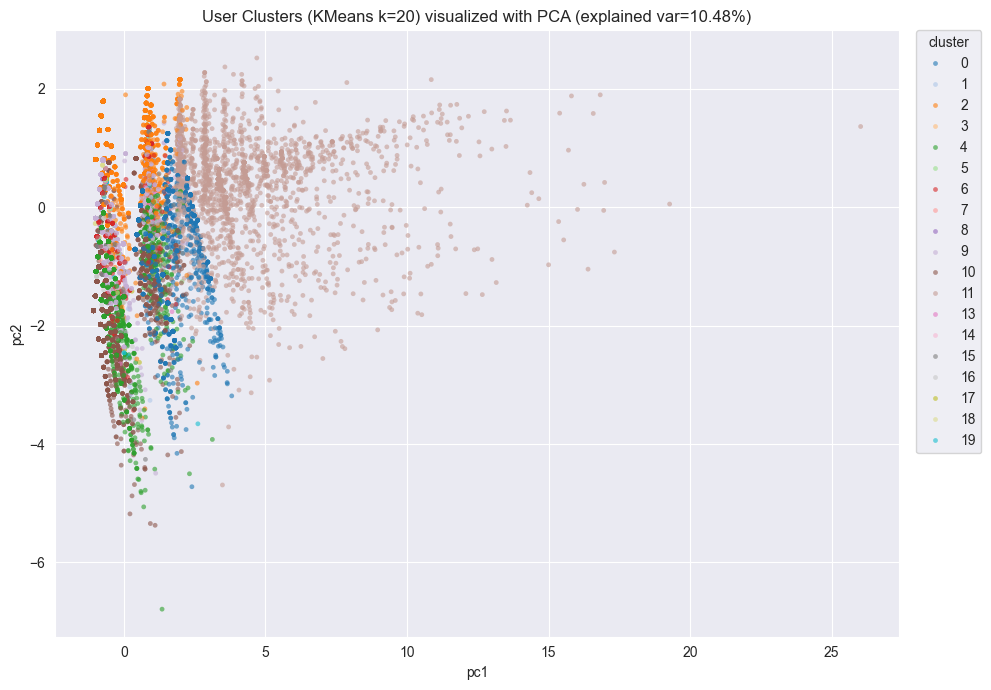

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 2D projection for visualization (PCA)
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

viz_df = pd.DataFrame(X_2d, columns=["pc1", "pc2"])
viz_df["cluster"] = user_features["cluster"].to_numpy()

# Optional: sample for speed/clarity (especially if you have many users)
n = min(30000, len(viz_df))
viz_df_plot = viz_df.sample(n=n, random_state=42) if len(viz_df) > n else viz_df

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=viz_df_plot,
    x="pc1",
    y="pc2",
    hue="cluster",
    palette="tab20",
    s=12,
    alpha=0.6,
    linewidth=0,
)
plt.title(f"User Clusters (KMeans k=20) visualized with PCA (explained var={pca.explained_variance_ratio_.sum():.2%})")
plt.legend(title="cluster", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


In [10]:
cat_cols = [c for c in user_features.columns if c.startswith("cat_share__")]
max_share = user_features[cat_cols].max(axis=1)
max_share.describe()

count    2.680421e+06
mean     9.517806e-01
std      1.455103e-01
min      1.666667e-01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

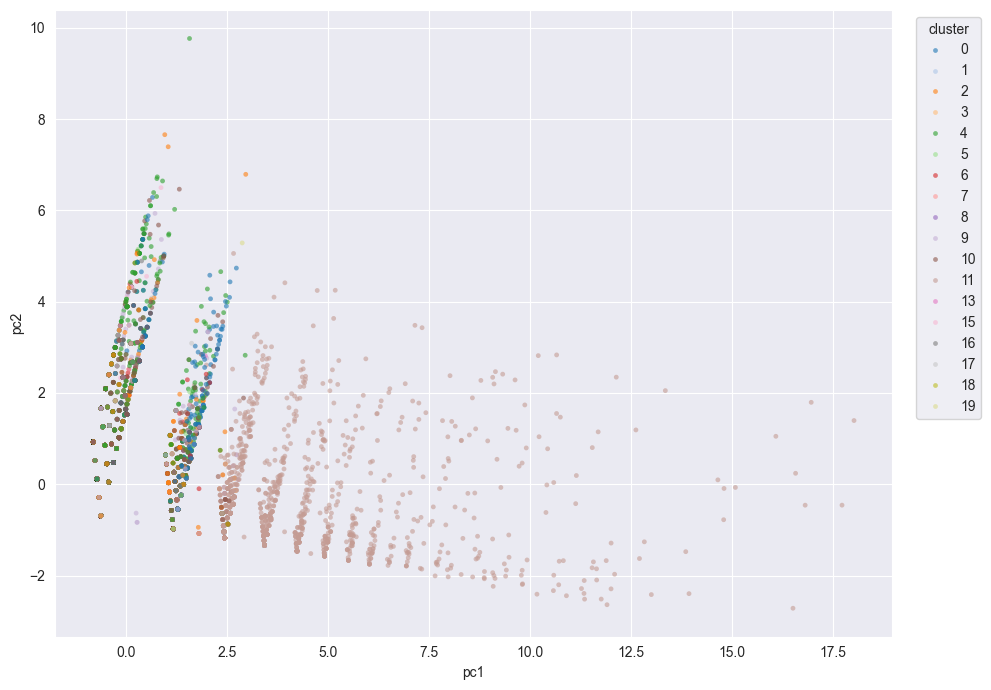

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

beh_cols = ["log_purchases", "log_products", "mean_rating", "share_verified",
            "log_helpful"]
Xb = StandardScaler().fit_transform(user_features[beh_cols].to_numpy())
Xb_2d = PCA(n_components=2, random_state=42).fit_transform(Xb)

vizb = pd.DataFrame(Xb_2d, columns=["pc1", "pc2"])
vizb["cluster"] = user_features["cluster"].to_numpy()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=vizb.sample(n=min(20000, len(vizb)), random_state=42),
    x="pc1", y="pc2",
    hue="cluster", palette="tab20",
    s=12, alpha=0.6, linewidth=0
)
plt.legend(title="cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

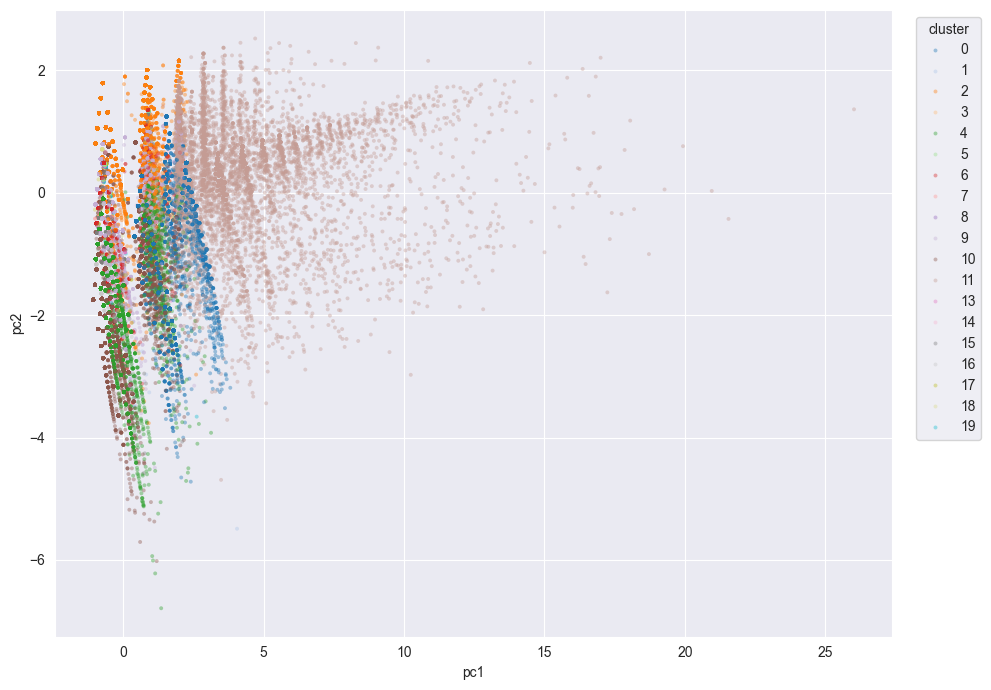

In [12]:
n_plot = 100_000
viz_df_plot = viz_df.sample(n=min(n_plot, len(viz_df)), random_state=42)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=viz_df_plot,
    x="pc1", y="pc2",
    hue="cluster",
    palette="tab20",
    s=8, alpha=0.4, linewidth=0
)
plt.legend(title="cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

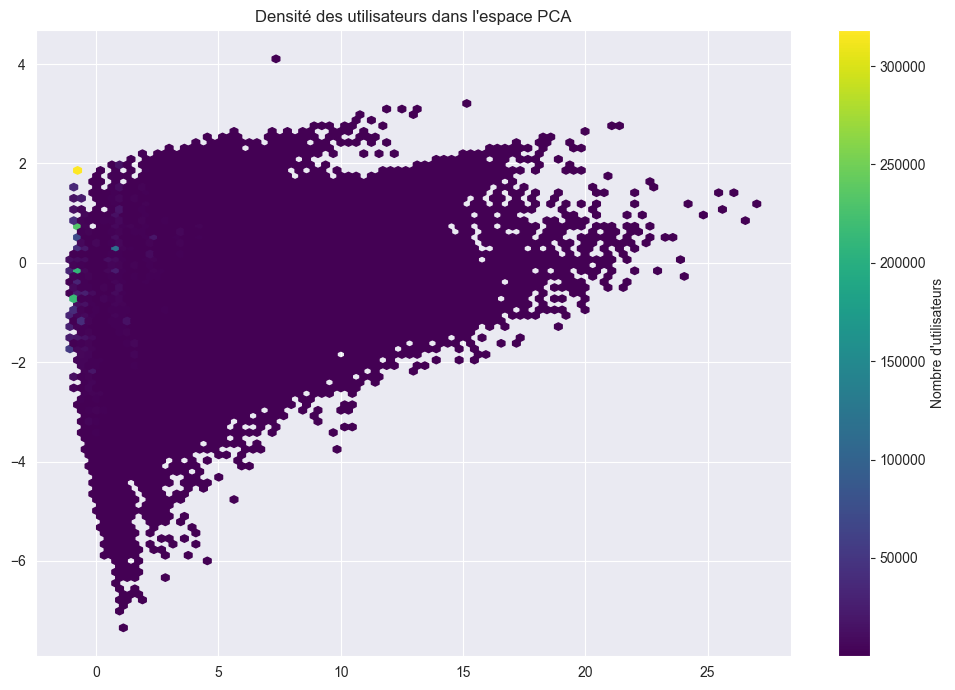

In [13]:
plt.figure(figsize=(10, 7))
plt.hexbin(viz_df["pc1"], viz_df["pc2"], gridsize=90, cmap="viridis", mincnt=1)
plt.colorbar(label="Nombre d'utilisateurs")
plt.title("Densité des utilisateurs dans l'espace PCA")
plt.tight_layout()
plt.show()


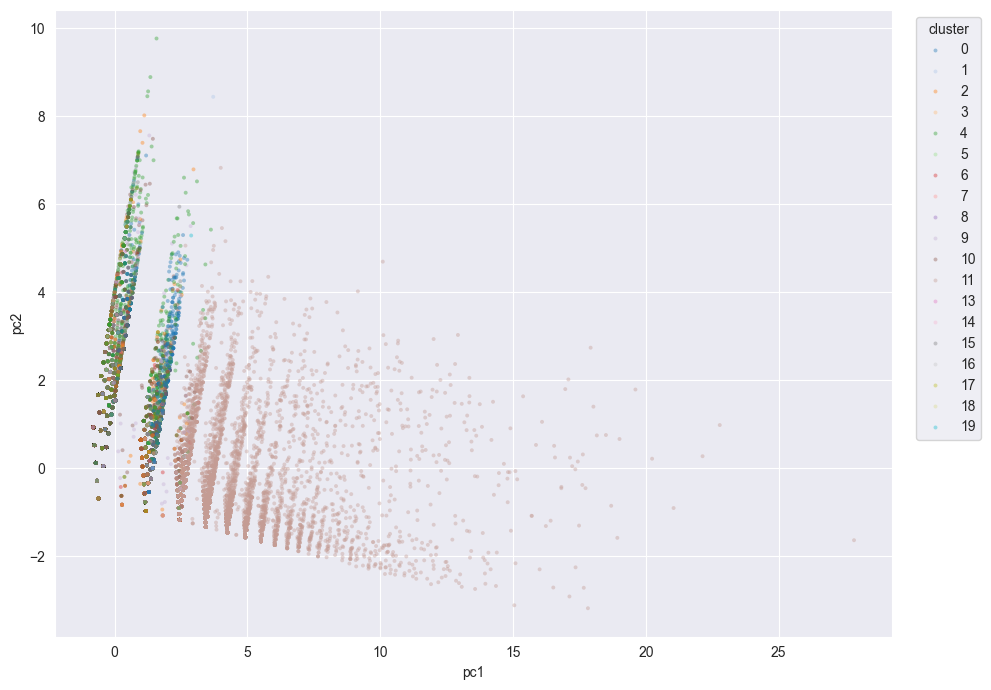

In [14]:
cat_cols = [c for c in user_features.columns if c.startswith("cat_share__")]
beh_cols = ["log_purchases", "log_products", "mean_rating", "share_verified",
            "log_helpful"]

# PCA comportement seulement
Xb = StandardScaler().fit_transform(user_features[beh_cols].to_numpy())
Xb_2d = PCA(n_components=2, random_state=42).fit_transform(Xb)

vizb = pd.DataFrame(Xb_2d, columns=["pc1", "pc2"])
vizb["cluster"] = user_features["cluster"].to_numpy()

vizb_plot = vizb.sample(n=min(100_000, len(vizb)), random_state=42)

plt.figure(figsize=(10, 7))
sns.scatterplot(data=vizb_plot, x="pc1", y="pc2", hue="cluster",
                palette="tab20", s=8, alpha=0.4, linewidth=0)
plt.legend(title="cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

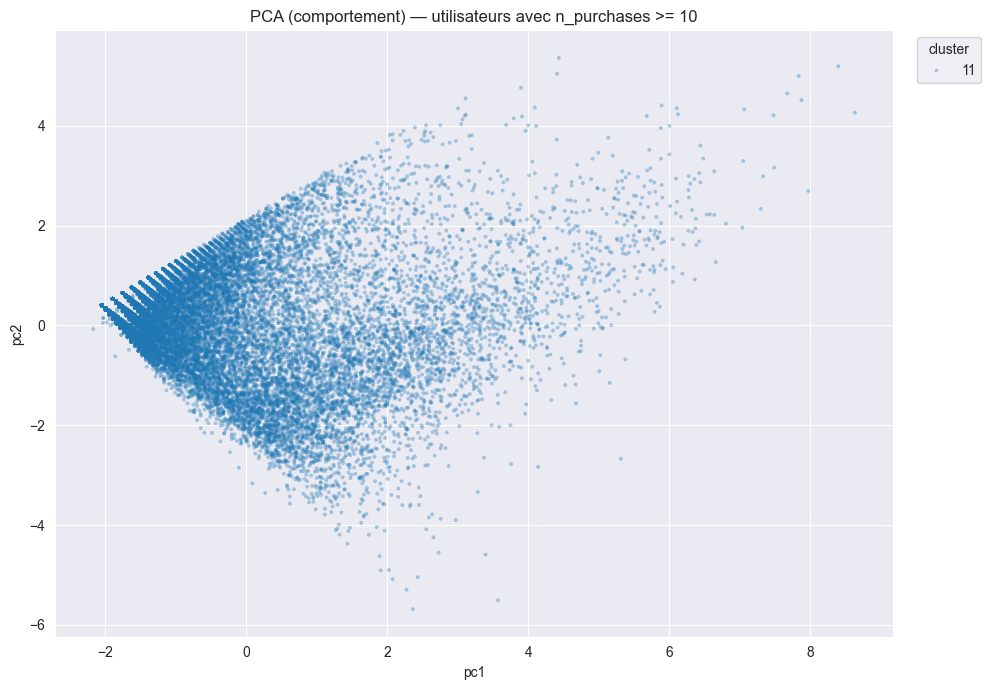

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

beh_cols = ["log_purchases", "log_products", "mean_rating", "share_verified", "log_helpful"]

mask = user_features["n_purchases"] >= 10
uf = user_features.loc[mask].copy()

Xb = StandardScaler().fit_transform(uf[beh_cols].to_numpy())
Xb_2d = PCA(n_components=2, random_state=42).fit_transform(Xb)

viz = pd.DataFrame(Xb_2d, columns=["pc1", "pc2"])
viz["cluster"] = uf["cluster"].to_numpy()

viz_plot = viz.sample(n=min(150_000, len(viz)), random_state=42)

plt.figure(figsize=(10, 7))
sns.scatterplot(data=viz_plot, x="pc1", y="pc2", hue="cluster",
                palette="tab20", s=8, alpha=0.35, linewidth=0)
plt.legend(title="cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.title("PCA (comportement) — utilisateurs avec n_purchases >= 10")
plt.tight_layout()
plt.show()


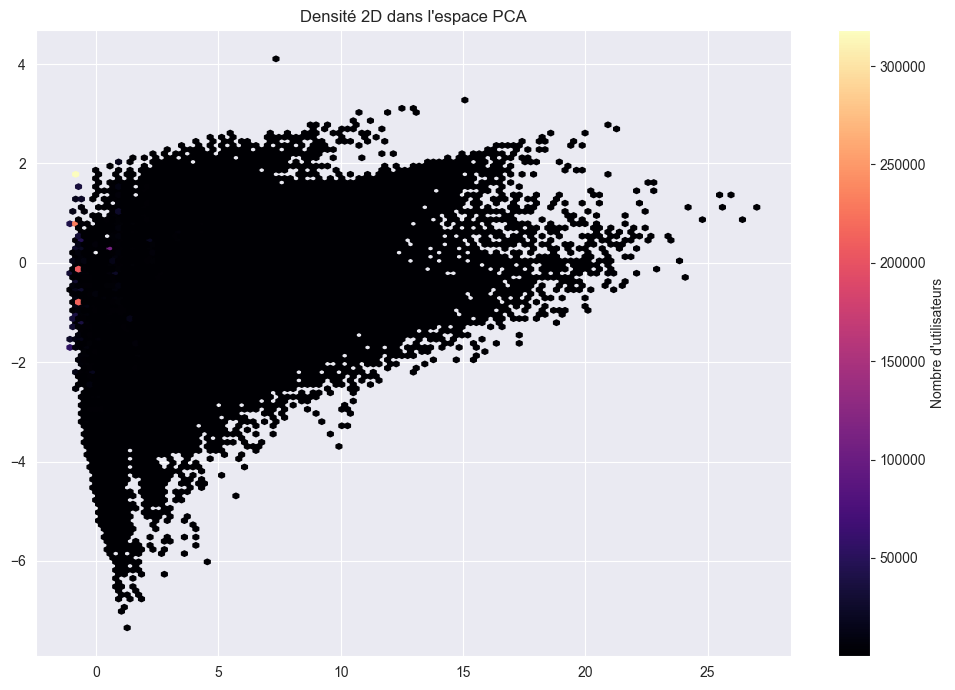

In [16]:
plt.figure(figsize=(10, 7))
plt.hexbin(viz_df["pc1"], viz_df["pc2"], gridsize=120, cmap="magma", mincnt=1)
plt.colorbar(label="Nombre d'utilisateurs")
plt.title("Densité 2D dans l'espace PCA")
plt.tight_layout()
plt.show()


In [17]:
user_features["n_purchases"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])


count    2.680421e+06
mean     1.472220e+00
std      3.625374e+00
min      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
90%      2.000000e+00
95%      3.000000e+00
99%      7.000000e+00
max      1.252000e+03
Name: n_purchases, dtype: float64